In [165]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, interpolate, optimize
import re #Regex

itam = (19.344443, -99.200117)
samplesize = 150
exporting = False

sns.set()

### Experimento con el metro: 
Dados puntos geográficos "disponibles", buscamos el óptimo con base en diferentes objetivos: 
- Distancia a estaciones del metro 
- Precios

Planteamos una función de $m$ objetivos a minimizar
$$ f(E) = k_1 \sum_{i=1}^{n} C_1(D_i) + k_2 \sum_{i=1}^{n} C_2(D_i) + \dots + k_m \sum_{i=1}^{n} C_m(D_n) $$ 
Donde $ E = (D_1, D_2, \ldots, D_n) $ y $C_1, C_2, \ldots, C_m $ son funciones de costo, y $ k_1, \ldots, k_m \in \mathbb{R} $ son escalares que actúan como "pesos"

Primer objetivo: 
Minimizar distancia. Primero, un estudio

In [2]:
t_publico = pd.read_csv("data/estaciones-metro.csv", delimiter=";")
t_publico.rename(columns={"stop_lat":"lat", "stop_lon":"lng"}, inplace=True)

t_publico.head()

,Geometry,stop_id,stop_code,stop_name,stop_desc,lat,lng,trip_heads,agency_id,Geopoint
0,"{""type"": ""Point"", ""coordinates"": [-99.139034, ...",14169.0,NaN,Garibaldi_1,Metro Línea 8 correspondencia con línea B.,19.443082,-99.139034,Garibaldi - Constitución de 1917,METRO,"19.443082, -99.139034"
1,"{""type"": ""Point"", ""coordinates"": [-99.136176, ...",14103.0,NaN,La Raza_1_3,Metro Línea 5 correspondencia con línea 3.,19.468965,-99.136176,Pantitlán - Politécnico,METRO,"19.468965, -99.136176"
2,"{""type"": ""Point"", ""coordinates"": [-99.18774605...",14079.0,NaN,Mixcoac_1,Metro Línea 7 correspondencia con línea 12.,19.376256,-99.187746,Tláhuac - Mixcoac,METRO,"19.37625563, -99.18774605"
3,"{""type"": ""Point"", ""coordinates"": [-99.12227869...",14144.0,NaN,Jamaica,Metro Línea 9 correspondencia con línea 4.,19.408944,-99.122279,Tacubaya - Pantitlán,METRO,"19.40894369, -99.12227869"
4,"{""type"": ""Point"", ""coordinates"": [-99.18686628...",132131.0,NaN,Mixcoac,Metro Línea 12 correspondencia con línea 7.,19.375679,-99.186866,Mixcoac - Tláhuac,METRO,"19.37567873, -99.18686628"


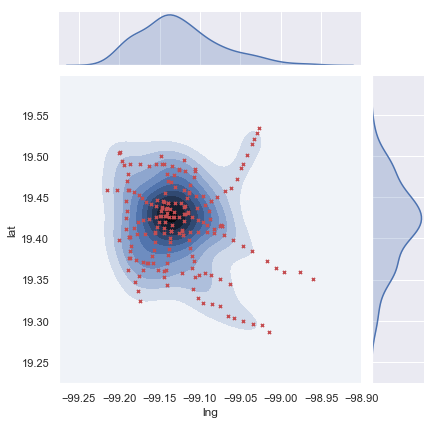

In [3]:
p = sns.jointplot(x="lng", y="lat", data=t_publico, kind="kde")
p.plot_joint(plt.scatter, c="r", s=10, marker="x")

if exporting: 
    p.savefig("distplo_metro.eps", format="eps" )

Técnica naive. Medimos la distancia de las coordenadas de una ubicación $P$ a la media de latitud y longitud $(\bar{x}, \bar{y})$ (Si, a pesar de que no es una geometría "plana", y la distancia no es solamente euclideana)

$C_1 := (x - \bar{x})^2 + (y - \bar{y})^2$

Posible mejora: Para evitar que se empiecen a juntar demasiado en el "centro", podemos anti-penalizar al punto $P$ restándole el promedio de las distancias medidas

In [4]:
def c_test(x, y, x_bar, y_bar): 
    return (x - x_bar)**2 + (y - y_bar)**2

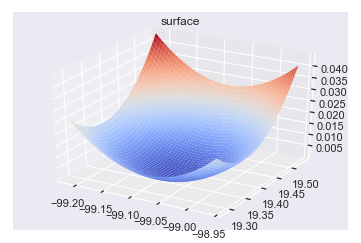

In [5]:
x_b = t_publico.lng.mean()
y_b = t_publico.lat.mean()

ex = np.linspace(t_publico.lng.min(), t_publico.lng.max(), samplesize)
ey = np.linspace(t_publico.lat.min(), t_publico.lat.max(), samplesize)

X, Y = np.meshgrid(ex, ey)

Z = c_test(X.T, Y.T, x_b, y_b)

fig, ax = plt.subplots()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm', edgecolor='none')
ax.set_title('surface');

if exporting: 
    fig.savefig("func1_metro.eps", format="eps" )

Veamos cómo se ajusta a los puntos

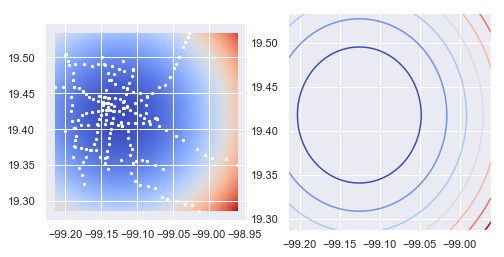

In [6]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4))
ax.imshow(np.rot90(Z), cmap="coolwarm",
          extent=[t_publico.lng.min(), t_publico.lng.max(), t_publico.lat.min(), t_publico.lat.max()])
ax.scatter(t_publico.lng, t_publico.lat, c="w", s=5)

ax2.contour(X, Y, Z.T, cmap="coolwarm")

if exporting: 
    fig.savefig("dist_func1_metro.eps", format="eps" )

Método ligeramente mejor: 
Para evitar que los puntos se acumulen en el mínimo de la parábola que forma $C_1$, con la distancia calculadad de un punto a una estación del metro dada, le restamos si "está cerca" de una estación, aun cuando no esté tan cerca de la mayor acumulación de estaciones

Intentamos hacer una función de kernel density estimator

In [7]:
# Creamos la función de kde gaussiana
# gaussian_kde recibe arreglos de (n x m) donde n es la cantidad de variables de la distribución
train_data = np.vstack([t_publico.lng, t_publico.lat])
kde_func = stats.gaussian_kde(train_data)

In [8]:
def c_test2(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X, Y])
    return - np.reshape(kde_func(positions).T, x.shape) + 80

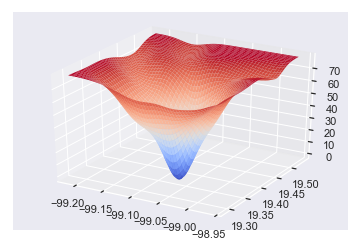

In [9]:
tx = np.linspace(t_publico.lng.min(), t_publico.lng.max(), samplesize)
ty = np.linspace(t_publico.lat.min(), t_publico.lat.max(), samplesize)
XX, YY = np.meshgrid(tx, ty)

ZZ = c_test2(XX.T, YY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(XX, YY, ZZ, cmap='coolwarm', edgecolor='none' )

if exporting: 
    fig.savefig("func2_metro.eps", format="eps" )

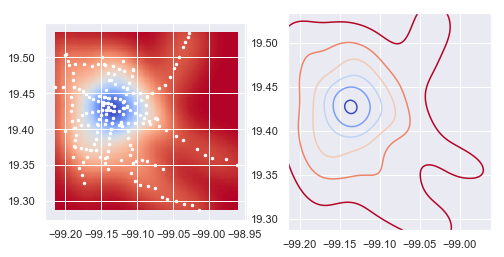

In [10]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4))
ax.imshow(np.rot90(ZZ), cmap="coolwarm",
          extent=[t_publico.lng.min(), t_publico.lng.max(), t_publico.lat.min(), t_publico.lat.max()])
ax.scatter(t_publico.lng, t_publico.lat, s=6, c="w")

ax2.contour(XX, YY, ZZ.T, cmap="coolwarm")

if exporting: 
    fig.savefig("dist_func2_metro.eps", format="eps" )

Ahora, tratamos de restarle importancia a estar cerca del centroide que se forma como consecuencia de la alta concentración de estaciones en un punto

In [11]:
# Creamos la función de kde gaussiana
# gaussian_kde recibe arreglos de (n x m) donde n es la cantidad de variables de la distribución
train_data = np.vstack([t_publico.lng, t_publico.lat])
kde_func = stats.gaussian_kde(train_data)

def c_test3(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X, Y])
    res =  np.reshape(kde_func(positions).T, x.shape)
    return - ( np.log(res) / np.log(1.1) ) + 50


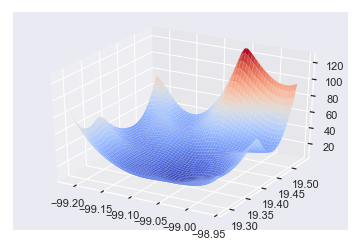

In [12]:
tx = np.linspace(t_publico.lng.min(), t_publico.lng.max(), samplesize)
ty = np.linspace(t_publico.lat.min(), t_publico.lat.max(), samplesize)
XX, YY = np.meshgrid(tx, ty)

# Nota: Quién sabe por qué hay que transponer XX y YY. Solo es asi. 
ZZ = c_test3(XX.T, YY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(XX, YY, ZZ, cmap='coolwarm', edgecolor='none' )

if exporting: 
    fig.savefig("figs/func3_metro.eps", format="eps" )

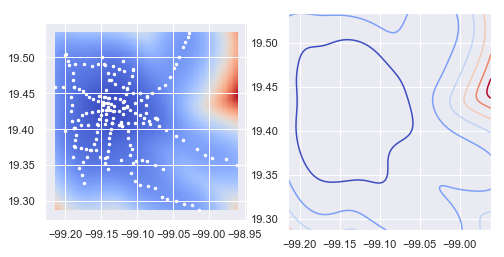

In [13]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4))
ax.imshow(np.rot90(ZZ), cmap="coolwarm",
          extent=[t_publico.lng.min(), t_publico.lng.max(), t_publico.lat.min(), t_publico.lat.max()])
ax.scatter(t_publico.lng, t_publico.lat, c="w", s=6)

ax2.contour(XX, YY, ZZ.T, cmap="coolwarm")

if exporting: 
    fig.savefig("figs/dist_func3_metro.eps", format="eps" )

La función no es perfecta (quizán una métrica de conexidad basado en distancia a lineas de metro sea mejor)

In [14]:
C_metro = c_test3

### Metrobus
Repetimos exactamento lo mismo que se hizo con el metro

In [15]:
metrobus = pd.read_csv("data/estaciones-metrobus.csv", delimiter=";")
metrobus.rename(columns={"Latitud": "lat", "Longitud": "lng"}, inplace=True)

metrobus.head()

,wkt_geom,Nombre,Línea,lng,lat,Geopoint
0,PointZ (-99.18675199999999847 19.4018399999999...,Terminal Tacubaya. Metrobús. Línea 2,Línea 2,-99.186752,19.401840,"19.40184, -99.186752"
1,PointZ (-99.18174700000001565 19.3650109999999...,Teatro de los Insurgentes,Línea 1,-99.181747,19.365011,"19.365011, -99.181747"
2,PointZ (-99.17604099999999789 19.3826010000000...,Ciudad de los Deportes,Línea 1,-99.176041,19.382601,"19.382601, -99.176041"
3,PointZ (-99.15722700000002021 19.4361519999999...,Plaza de la República,Línea 1,-99.157227,19.436152,"19.436152, -99.157227"
4,PointZ (-99.182715999999985 19.361983999999999...,José María Velasco,Línea 1,-99.182716,19.361984,"19.361984, -99.182716"


Estudio rápido 

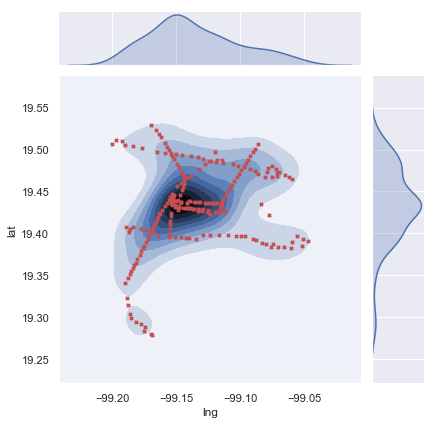

In [16]:
pp = sns.jointplot(x="lng", y="lat", data=metrobus, kind="kde")
pp.plot_joint(plt.scatter, c="r", s=10, marker="X")

if exporting: 
    pp.savefig("figs/distplo_metrobus.eps", format="eps" )

Creando la función de densidad de probabilidad para el metrobus

In [17]:
mbus_traindata = np.vstack([metrobus.lng, metrobus.lat])
mbus_kde = stats.gaussian_kde(mbus_traindata)

def mb_test(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X,Y])
    res = np.reshape(mbus_kde(positions), x.shape )
    
    return - res + 140

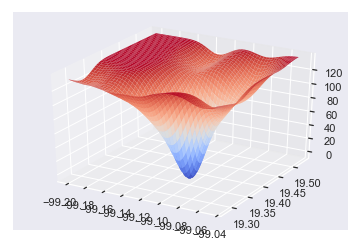

In [18]:
mx = np.linspace(metrobus.lng.min(), metrobus.lng.max(), samplesize)
my = np.linspace(metrobus.lat.min(), metrobus.lat.max(), samplesize)

xX, yY = np.meshgrid(mx, my)

#Evaluando la función
zZ = mb_test(xX.T, yY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(xX, yY, zZ, cmap="coolwarm", edgecolor="none")

if exporting: 
    fig.savefig("func1_metrobus.eps", format="eps" )

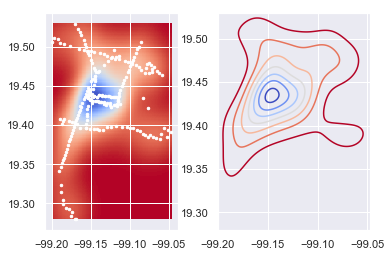

In [19]:
fig, [ax, ax2] = plt.subplots(1,2)
ax.imshow(np.rot90(zZ), cmap="coolwarm", 
         extent=[metrobus.lng.min(), metrobus.lng.max(), metrobus.lat.min(), metrobus.lat.max()])
ax.scatter(metrobus.lng, metrobus.lat,c="w", s=6)

ax2.contour(xX, yY, zZ.T, cmap="coolwarm")

if exporting: 
    fig.savefig("dist_func1_metrobus.eps", format="eps" )

De nuevo, ajustamos para no penalizar tanto a los puntos alejados del centroide

In [20]:
mbus_traindata = np.vstack([metrobus.lng, metrobus.lat])
mbus_kde = stats.gaussian_kde(mbus_traindata)

def mb_test(x, y): 
    X = x.ravel()
    Y = y.ravel()
    positions = np.vstack([X,Y])
    res = np.reshape(mbus_kde(positions).T, x.shape )
    
    return - (np.log(res) / np.log(1.2)) + 30

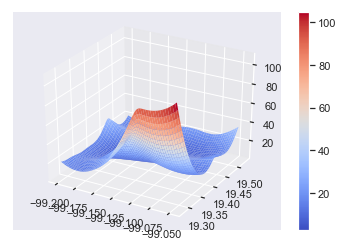

In [21]:
mx = np.linspace(metrobus.lng.min(), metrobus.lng.max(), samplesize)
my = np.linspace(metrobus.lat.min(), metrobus.lat.max(), samplesize)

xX, yY = np.meshgrid(mx, my)

#Evaluando la función
zZ = mb_test(xX.T, yY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
surf = ax.plot_surface(xX, yY, zZ.T, cmap="coolwarm", edgecolor="none")
fig.colorbar(surf)

if exporting: 
    fig.savefig("func2_metrobus.eps", format="eps" )

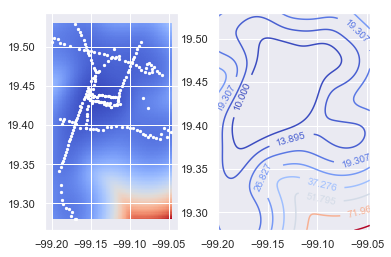

In [22]:
fig, [ax, ax2] = plt.subplots(1,2)
ax.imshow(np.rot90(zZ), cmap="coolwarm", 
         extent=[metrobus.lng.min(), metrobus.lng.max(), metrobus.lat.min(), metrobus.lat.max()])
ax.scatter(metrobus.lng, metrobus.lat, s=5, c="w")

cont = ax2.contour(xX, yY, zZ.T, np.logspace(1, 8), cmap="coolwarm")
ax2.clabel(cont, inline=1)

if exporting: 
    fig.savefig("dist_func2_metrobus.eps", format="eps" )

De nuevo, la función no es perfecta, pero se asienta como la función de costos asociada al metrobus

In [23]:
C_metrobus = mb_test

Ahora visualizamos ambas funciones en acción 
$$ C_{\text{transporte}} = C_{\text{M}} + C_{\text{Mb}} $$

In [24]:
def C_transporte(X, Y): 
    return C_metro(X, Y) + C_metrobus(X, Y)

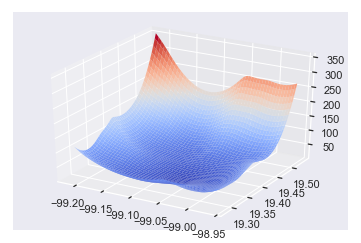

In [25]:
min_lng = min(t_publico.lng.min(), metrobus.lng.min())
min_lat = min(t_publico.lat.min(), metrobus.lat.min())
max_lng = max(t_publico.lng.max(), metrobus.lng.max())
max_lat =  max(t_publico.lat.max(), metrobus.lat.max())
ax = np.linspace(min_lng, max_lng, samplesize)
ay = np.linspace(min_lat, max_lat, samplesize)

aX, aY = np.meshgrid(ax, ay)

aZ = C_transporte(aX.T, aY.T)

fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(aX, aY, aZ, cmap="coolwarm", edgecolor="none")

if exporting: 
    fig.savefig("func_transporte.eps", format="eps" )

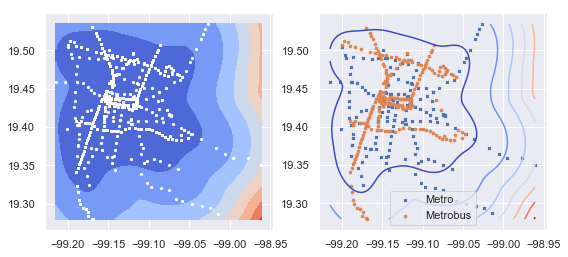

In [46]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(9,4))
#ax.imshow(np.rot90(aZ), cmap="coolwarm", extent=[min_lng, max_lng, min_lat, max_lat])
ax.contourf(aX, aY, aZ.T, cmap="coolwarm")
ax.scatter(t_publico.lng, t_publico.lat, s=5, c="w")
ax.scatter(metrobus.lng, metrobus.lat, s=5, c="w", marker="s")

ax2.contour(aX, aY, aZ.T, cmap="coolwarm")
ax2.scatter(t_publico.lng, t_publico.lat, s=7, marker="x", label="Metro")
ax2.scatter(metrobus.lng, metrobus.lat, s=7, label="Metrobus")
ax2.legend()

if exporting: 
    fig.savefig("dist_func_transporte.eps", format="eps" )

#### Optimización
Le aventamos todo el arsenal de scipy 

In [27]:
#Aprendiendo a usar optimize
def C_trans(X): 
    return C_metro(X[0], X[1]) + C_metrobus(X[0], X[1])

x_0 = [metrobus.lng.mean(), metrobus.lat.mean()]
print(x_0)
res = optimize.minimize(C_trans, x_0, method="BFGS", options={"disp":True})
print(res)
print(res.x == x_0)

[-99.13535967948717, 19.433253863247863]
Optimization terminated successfully.
         Current function value: 6.738575
         Iterations: 7
         Function evaluations: 53
         Gradient evaluations: 12
      fun: 6.738574816246885
 hess_inv: array([[5.54284236e-05, 2.09697742e-07],
       [2.09697742e-07, 5.01066103e-05]])
      jac: array([-2.38418579e-07, -2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 53
      nit: 7
     njev: 12
   status: 0
  success: True
        x: array([-99.14132674,  19.43121284])
[False False]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in

#### Breve paréntesis exploratorio para aprender scipy.optimize

- Usamos la función Rosenbrock en los ejemplos $$ f(x,y) = (1-x)^2 + b (y-x^2)^2 $$

                        fun: 3.013229928290545e-14
 lowest_optimization_result:      fun: 3.013229928290545e-14
     jac: array([7.20982493e-06, 7.03809655e-07])
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 10
    njev: 24
  status: 0
 success: True
       x: array([0.99999983, 0.99999966])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 9
                       nfev: 14795
                        nit: 100
                       njev: 3655
                          x: array([0.99999983, 0.99999966])


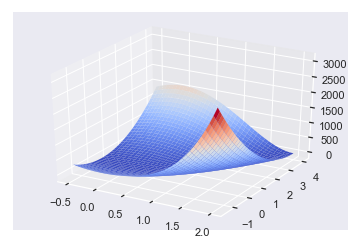

In [34]:
r = optimize.basinhopping(optimize.rosen, [2, -1], minimizer_kwargs={"method":"CG"})    

print(r)
#Plotting 

X,Y = np.meshgrid(np.linspace(-.5, 2., 40), np.linspace(-1.5, 4., 40))
Z = optimize.rosen([X,Y])



fig, ax = plt.subplots()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor="none")
ax.scatter(r.x[0], r.x[1], 1, c="r")


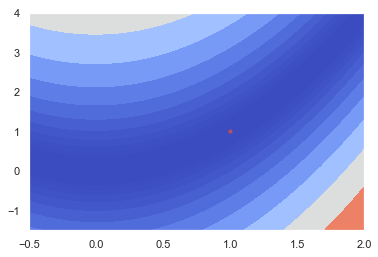

In [36]:
fig, ax = plt.subplots()
ax.contourf(X,Y,Z, np.logspace(-0.5,  3.5, 20, base = 10),  cmap="coolwarm")
ax.plot(0.99999823, 0.99999647, "r.")


Curve fitting
- Función de prueba: $$ f(x) = a e^{-b x} + c $$

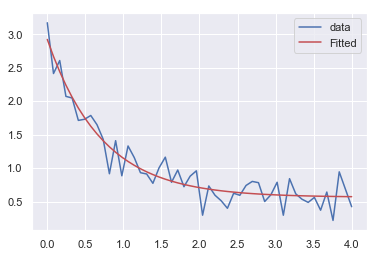

In [30]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise


plt.plot(xdata, ydata, 'b-', label='data')

popt, pcov = optimize.curve_fit(func, xdata, ydata)

plt.plot(xdata, func(xdata, *popt), 'r-', label="Fitted")
plt.legend()

Ahora, web scraping para encontrar puntos de prueba

In [1]:
from bs4 import BeautifulSoup
import requests 

In [3]:
page = requests.get("https://inmuebles.mercadolibre.com.mx/oficinas/distrito-federal/")
soup = BeautifulSoup(page.content, "html.parser")


Queremos: 
1. Iterar sobre los resultados de oficionas en cdmx 
2. Por cada l.i del div id="searchResults"
    - Entrar al link de esa publicación 
    - Scrapear datos de la publicacion: 
    en div class="data-info-price" está el precio 
    
    en div class="item-title__primary" está el titulo 
    
    en div id="sectionDynamicMap" está la info de ubicación
    
##### Nota: Esa celda tarda mucho en ejecutar. Es normal. Está haciendo requests a internet




In [190]:


# Creando rows para crear dataFrame después 
row_list = []

items = soup.find_all("a", class_="item-link item__js-link" )
for item in items:
    link_item = item.get("href")
    
    #Obteniendo la página del resultado
    publicacion = requests.get(link_item)
    pub_soup = BeautifulSoup(publicacion.content, "html.parser")
    
    # Navegando la página del resultado para obtener precio, nobre, ubicación 
    nombre_p = pub_soup.find("h1", class_ = "item-title__primary").string.rstrip()
    precio_p = pub_soup.find("span", class_ = "price-tag-fraction").string
    precio_num = float(precio_p.replace(",",""))
    
    # Encontrando lat, lng de javascript
    # Nota: El número index mágico en js_script no está garantizado que funcione
    for script in pub_soup.find_all("script", {"src":False}):
        if script: 
            # Regex evil 
            lng_regex = re.compile("longitude: (.*)")
            lat_regex = re.compile("latitude: (.*)")
    
            lng_str = lng_regex.search(script.text)
            lat_str = lat_regex.search(script.text)
            
            
            if lat_str and lng_str:
                # Recuperamos floats de strings de lat, lng. Más evil regex
                lat_float = float(re.findall("[-]?\d+\.\d+", lat_str[0])[0])
                lng_float = float(re.findall("[-]?\d+\.\d+", lng_str[0])[0])
                
                print(lat_float)
    
    
    
    if lat_str and lng_str:
        # Recuperamos floats de strings de lat, lng. Más evil regex
        lat_float = float(re.findall("[-]?\d+\.\d+", lat_str[0])[0])
        lng_float = float(re.findall("[-]?\d+\.\d+", lng_str[0])[0])
        
        # Añadiendo a pandas
        row_dict = {"Nombre" : nombre_p, "Precio" : precio_num, "lat" : lat_float, "lng" : lng_float }
        row_list.append(row_dict)
        
    else: 
        # Preparando para pandas
        row_dict = {"Nombre" : nombre_p, "Precio" : precio_num, "lat" : np.nan, "lng" : np.nan }
        row_list.append(row_dict)
        
propiedades = pd.DataFrame(row_list)
        

entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
19.321789
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
19.4537943
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
19.3878023
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
19.4062293
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
19.3749589
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
19.4141369
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada
entrada

KeyboardInterrupt: 

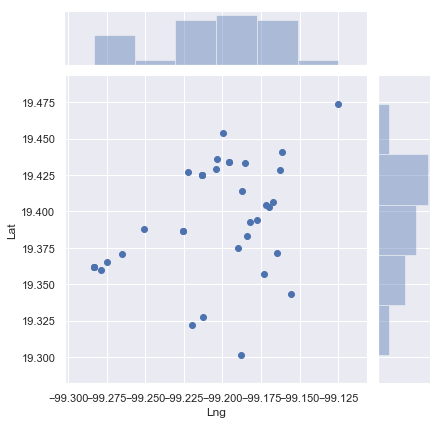

In [178]:
sns.jointplot(x="Lng", y="Lat", data=propiedades)